<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2023/blob/main/Module%207/MidTerm_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MidTerm - 2 for the Fall 2023 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin

Special point:
- ChatGPT will augment your power as a coder
- If and only if you know what you want to accomplish!

# 1.Bandits

1. Explain the Multi-Armed Bandit Problem: Describe the multi-armed bandit problem in the context of decision making and explain how it differs from traditional A/B testing.

Answer:

2. Epsilon-Greedy Strategy: Explain what the epsilon-greedy strategy is in the context of bandits and decision making. Discuss its advantages and potential drawbacks.


Answer:

3. Upper Confidence Bound (UCB): Describe the UCB algorithm and explain how it balances exploration and exploitation in the context of a multi-armed bandit problem.

Answer:

4. Thompson Sampling: Explain the concept of Thompson Sampling in bandit problems. How does it approach the exploration-exploitation tradeoff?

Answer:

5. Regret in Bandit Problems: Define 'regret' in the context of multi-armed bandit problems. How is it used to evaluate the performance of a bandit algorithm?

Answer:

6. Contextual Bandits: Explain what contextual bandits are and how they differ from basic multi-armed bandits. Provide an example of a real-world application where contextual bandits would be useful.

Answer:

# 2.Bandit costs

7. Consider the business case of the ad placing on the website. Create the multiarmed bandit with 4 hands, with the probabilities of win sampled from Uniform distributions [0, 0.1] for arm 1, [0, 0.2] from arm 2, [0.1, 0.3] from arm 3, and [0.2 0.4] form arm 4.

8. Assume that the reward from arm 1 is 1, arm 2 is 3, arm 3 is 2, and arm 4 is 1.5. Calculate the expected gain for epsilon-greedy testing with the several values of epsilon, e.g. 0.01, 0.03, 0.1, and 0.3

9. Assume that your experimental budget is 1000 iterations. Which epsilon value will you choose to maximize your reward?

10. Will the answer change if you have only 30 attempts?

# 3.Rewards and objectives

Pick a paper of you choice (ideally targeting materials discovery or optimization). Identify the range of objectives motivating the work, and reward function used by the authors. What was their measure of success?

11. Provide the link to the paper

Answer:

12. Describe global objective

Answer:

13. Describe more local (immediate) objectives

Answer:

14. What was the reward de-facto used in the paper (how did the authors quantify success)?

Answer:

15. If you were setting the automated experiment following the same objectives as the paper, how would you define the reward (measure of success)?

Answer:

# 4.Molecular discovery

Now, let's experiment with real machine learning in chemistry. We are going to download the QM9 data set of molecular structure and properties. Before doing is so, let's explore the concept of chemical space.

16. Explore "chemical space" on Wikipedia.
- How large is it?
- How large is QM9 data set?
- How were the molecules for QM9 chosen?

16. Answer:

- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh, research.aghosh@gmail.com

## Install RDkit and Selfies

In [1]:
!pip install rdkit-pypi
!pip install selfies --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 65.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

import torch
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize

import selfies as sf

In [3]:
def parse_float(s: str) -> float:
    try:
        return float(s)
    except ValueError:
        base, power = s.split('*^')
        return float(base) * 10**float(power)

def parse_xyz(filename):
    """
    Parses QM9 specific xyz files.
    :param filename: str path to file
    :return:
    """
    num_atoms = 0
    scalar_properties = []
    atomic_symbols = []
    xyz = []
    charges = []
    harmonic_vibrational_frequencies = []
    smiles = ''
    inchi = ''
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                num_atoms = int(line)
            elif line_num == 1:
                scalar_properties = [float(i) for i in line.split()[2:]]
            elif 2 <= line_num <= 1 + num_atoms:
                atom_symbol, x, y, z, charge = line.split()
                atomic_symbols.append(atom_symbol)
                xyz.append([parse_float(x), parse_float(y), parse_float(z)])
                charges.append(parse_float(charge))
            elif line_num == num_atoms + 2:
                harmonic_vibrational_frequencies = [float(i) for i in line.split()]
            elif line_num == num_atoms + 3:
                smiles = line.split()[0]
            elif line_num == num_atoms + 4:
                inchi = line.split()[0]

    result = {
        'num_atoms': num_atoms,
        'atomic_symbols': atomic_symbols,
        'pos': torch.tensor(xyz),
        'charges': np.array(charges),
        'harmonic_oscillator_frequencies': harmonic_vibrational_frequencies,
        'smiles': smiles,
        'inchi': inchi
    }
    scalar_property_labels = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv']
    scalar_properties = dict(zip(scalar_property_labels, scalar_properties))
    result.update(scalar_properties)
    return result

## Download the data

In [4]:
!gdown https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF

Downloading...
From: https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF
To: /content/dsgdb9nsd.xyz.tar.bz2
100% 86.1M/86.1M [00:00<00:00, 183MB/s]


Generate lists of SMILE strings and append with properties that we can directly retrieve from the QM9 dataset

17. What are SMILES and when were they invented (note that ChatGPT is unlikely to produce the correct citation - so Wikipedia can help)?

Answer:

In [5]:
!mkdir /content/Molecules
!tar -C Molecules -xvf /content/dsgdb9nsd.xyz.tar.bz2

Streaming output truncated to the last 5000 lines.
dsgdb9nsd_128886.xyz
dsgdb9nsd_128887.xyz
dsgdb9nsd_128888.xyz
dsgdb9nsd_128889.xyz
dsgdb9nsd_128890.xyz
dsgdb9nsd_128891.xyz
dsgdb9nsd_128892.xyz
dsgdb9nsd_128893.xyz
dsgdb9nsd_128894.xyz
dsgdb9nsd_128895.xyz
dsgdb9nsd_128896.xyz
dsgdb9nsd_128897.xyz
dsgdb9nsd_128898.xyz
dsgdb9nsd_128899.xyz
dsgdb9nsd_128900.xyz
dsgdb9nsd_128901.xyz
dsgdb9nsd_128902.xyz
dsgdb9nsd_128903.xyz
dsgdb9nsd_128904.xyz
dsgdb9nsd_128905.xyz
dsgdb9nsd_128906.xyz
dsgdb9nsd_128907.xyz
dsgdb9nsd_128908.xyz
dsgdb9nsd_128909.xyz
dsgdb9nsd_128910.xyz
dsgdb9nsd_128911.xyz
dsgdb9nsd_128912.xyz
dsgdb9nsd_128913.xyz
dsgdb9nsd_128914.xyz
dsgdb9nsd_128915.xyz
dsgdb9nsd_128916.xyz
dsgdb9nsd_128917.xyz
dsgdb9nsd_128918.xyz
dsgdb9nsd_128919.xyz
dsgdb9nsd_128920.xyz
dsgdb9nsd_128921.xyz
dsgdb9nsd_128922.xyz
dsgdb9nsd_128923.xyz
dsgdb9nsd_128924.xyz
dsgdb9nsd_128925.xyz
dsgdb9nsd_128926.xyz
dsgdb9nsd_128927.xyz
dsgdb9nsd_128928.xyz
dsgdb9nsd_128929.xyz
dsgdb9nsd_128930.xyz
dsgd

In [6]:
smiles = []
enthalpy = []
u0 = []
u = []
g = []
alpha = []
r2 = []
mu = []

#may need to change the path
filenames = glob.glob('/content/Molecules/*.xyz')

#may need to go through the full range
for fid in range(5000):
    x = parse_xyz(filenames[fid])
    smiles_loc = x['smiles']
    enthalpy_loc = x['h']
    dipole_moment = x['mu']
    homo_loc = x['homo']
    lumo_loc = x['lumo']
    gap_loc = x['gap']
    zpve_loc = x['zpve']
    u0_loc = x['u0']
    u_loc = x['u']
    g_loc = x['g']
    alpha_loc = x['alpha']
    r2_loc = x['r2']
    smiles.append(smiles_loc)
    mu.append(dipole_moment)
    enthalpy.append(enthalpy_loc)
    u0.append(u0_loc)
    u.append(u_loc)
    g.append(g_loc)
    alpha.append(alpha_loc)
    r2.append(r2_loc)

Let's compute few basic features and put together a dataset. Features we compute:
- molecular weight,
- topological polar surface area,
- molar log P,
- number of hydrogen bond donors,
- acceptors,
- valence electrons,
- maximum partial charge,
- minimum partial charge,
- number of rotatable bonds,
- number of ring counts,
- number of stereocenters

In [7]:
mol_wt, tpsa, logp_ml, hbd, hba  = [], [], [], [], []
vale, partialcg_max, partialcg_min, rotbd, ringct, stereoct = [], [], [], [], [], []

for i in range(len(smiles)):
    m = Chem.MolFromSmiles(smiles[i])
    mol_wt_l = Descriptors.ExactMolWt(m)
    tpsa_l, logp_l = Descriptors.TPSA(m), Descriptors.MolLogP(m)
    hbd_l, hba_l = Descriptors.NumHDonors(m), Descriptors.NumHAcceptors(m)
    vale_l = Descriptors.NumValenceElectrons(m),
    partialcharge_max_l, partialcharge_min_l = Descriptors.MaxPartialCharge(m), Descriptors.MinPartialCharge(m)
    rotbd_l = Descriptors.NumRotatableBonds(m)
    ring_ct, stereo_cent = Descriptors.RingCount(m), rdMolDescriptors.CalcNumAtomStereoCenters(m)

    mol_wt.append(mol_wt_l)
    tpsa.append(tpsa_l)
    logp_ml.append(logp_l)
    hbd.append(hbd_l)
    hba.append(hba_l)
    vale.append(vale_l)
    partialcg_max.append(partialcharge_max_l)
    partialcg_min.append(partialcharge_min_l)
    rotbd.append(rotbd_l)
    ringct.append(ring_ct)
    stereoct.append(stereo_cent)

New dataset with few features with SMILE strings

In [8]:
df = pd.DataFrame({'smiles': smiles, 'mole_logp': logp_ml,'tpsa': tpsa, 'mol_wt' : mol_wt,
                   'hbd': hbd, 'hba':hba, 'valencee':vale, 'max_partialcharge':partialcg_max, 'min_partialcharge':partialcg_min,
                   'rotatablebd':rotbd, 'ringct':ringct, 'stereocent': stereoct, 'dipole_moment':mu})

In [9]:
df

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
0,CC1C2C3C1C(C)(C)N23,1.09730,3.01,123.104799,0,1,"(50,)",0.031211,-0.288190,0,3,5,1.6097
1,C#CC#CC1CN1,-0.40520,21.94,91.042199,1,1,"(34,)",0.082698,-0.300043,0,1,1,1.1151
2,CC1=COC=C1C=O,1.40052,30.21,110.036779,0,2,"(42,)",0.153043,-0.471575,1,1,0,3.2172
3,CC1C2C=CC(=O)C12O,0.12230,37.30,124.052429,1,2,"(48,)",0.187277,-0.380762,0,2,3,2.9412
4,CC1COC(C1)C=O,0.61030,26.30,114.068080,0,2,"(46,)",0.148264,-0.370464,1,1,2,3.1893
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,OC1CCC2(NC12)C=O,-0.94940,59.24,127.063329,2,3,"(50,)",0.141249,-0.391414,1,2,3,1.6268
4996,COCC#CCNC=O,-0.61780,38.33,127.063329,1,2,"(50,)",0.207375,-0.372020,3,0,0,4.6315
4997,O=C1CCN2N=CN=C12,-0.13550,47.78,123.043262,0,4,"(46,)",0.201128,-0.290587,0,2,0,4.1198
4998,CCC1(O)CC2(CN2)C1,0.26330,42.17,127.099714,2,2,"(52,)",0.068087,-0.389757,1,2,0,2.2262


## Convert SMILEs to SELFIEs

18. As an excercise, read the SELFIES paper (https://github.com/aspuru-guzik-group/selfies) and describe the difference between SMILES and SELFIEs

Answer:

In [10]:
smiles

['CC1C2C3C1C(C)(C)N23',
 'C#CC#CC1CN1',
 'CC1=COC=C1C=O',
 'CC1C2C=CC(=O)C12O',
 'CC1COC(C1)C=O',
 'CC1=CN=C(N)N=C1C',
 'C1OC1C1C2C3CC2N13',
 'OC12C3CC4C(C13)C24O',
 'CC#CC#CC1CC1O',
 'CCC#CC#CC#C',
 'CN1CCC=C(C1)C#N',
 'CC1C2CNC(=O)C12C',
 'COC(=O)COCC#C',
 'CC(C)CCNC(N)=O',
 'CC(=O)CC1CC1C#C',
 'C1C2CC3C4OC1C2C34',
 'FC(F)(F)C1=CNC=N1',
 'CN(C)C1=CNC=C1',
 'COC1C2OC(C#C)C12',
 'CC1CN2C1C2(C)C#C',
 'CCC#CC1CO1',
 'CN1CC(C1)OCCO',
 'CC1CC2C(C#N)C12',
 'O=C1CCC=CC1C#N',
 'O=C1NCC11C2CC1C2',
 'OCCN=COCC#N',
 'N=C1OC2CC12C#C',
 'CC1COC2=NCCC12',
 'NC1=COC=C1OC=N',
 'CC([NH3+])CC#CC([O-])=O',
 'OCC1CCCCC1O',
 'CN(C)C1=NOC(=N)N1',
 'O=C1CNC2CC2C=C1',
 'CCC(C)C1(CC)CC1',
 '[O-]C(=O)C1[NH2+]CC2CC12',
 'C1C2C1C1C=CCCC21',
 'CC12CC(C1)CC(=O)O2',
 'CCOC1CCN=CO1',
 'N=C1N=CON=NC1=O',
 'CC(=O)C1=CN=C(N)O1',
 'CC(=N)OC1=CON=N1',
 'CC1(CN2CC2)CC1',
 'CC1=NOC=C(N)C1=O',
 'CC1CC(O)(C=O)C1O',
 'CC(C)CCC#C',
 'CC1CN1C(=O)CC#C',
 'CCCOC1=CN=NO1',
 'CC1(C)CC2=NC=NN12',
 'OC(CC=O)(C#C)C#N',
 'CNC1=NOC(OC)=

The SELFIES have some limitations on acceptable bonding. So we refine the data set to remove the molecules that do not fit into supported semantic constraints.

In [11]:
selfies_dataset = []
error_smiles = []

for i in range(len(smiles)):
    try:
        local_sf = sf.encoder(smiles[i])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(smiles[i])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

Error encoding SMILES at index 1004: input violates the currently-set semantic constraints
	SMILES: O=N(=O)C1=NOC=N1
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 1194: input violates the currently-set semantic constraints
	SMILES: NC1=C(NN=C1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2148: input violates the currently-set semantic constraints
	SMILES: CC1=NNN=C1N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2344: input violates the currently-set semantic constraints
	SMILES: O=N(=O)C1=CN=CN=C1
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 4409: input violates the currently-set semantic constraints
	SMILES: NC1=C(C=NO1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 4427: input violates the currently-set semant

Let's see what these molecules are....

In [12]:
error_smiles_set = set(error_smiles)
error_smiles_set

{'CC1=CC(=NO1)N(=O)=O',
 'CC1=NNN=C1N(=O)=O',
 'NC1=C(C=NO1)N(=O)=O',
 'NC1=C(NN=C1)N(=O)=O',
 'O=N(=O)C1=CN=CN=C1',
 'O=N(=O)C1=CNC=C1',
 'O=N(=O)C1=NOC=N1'}

... how many of them are there

In [13]:
df['smiles'].isin(error_smiles_set).sum()

7

And remove them from the dataframe

In [14]:
df_filtered = df[~df['smiles'].isin(error_smiles_set)]
df_filtered.tail(5)

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
4995,OC1CCC2(NC12)C=O,-0.9494,59.24,127.063329,2,3,"(50,)",0.141249,-0.391414,1,2,3,1.6268
4996,COCC#CCNC=O,-0.6178,38.33,127.063329,1,2,"(50,)",0.207375,-0.372020,3,0,0,4.6315
4997,O=C1CCN2N=CN=C12,-0.1355,47.78,123.043262,0,4,"(46,)",0.201128,-0.290587,0,2,0,4.1198
4998,CCC1(O)CC2(CN2)C1,0.2633,42.17,127.099714,2,2,"(52,)",0.068087,-0.389757,1,2,0,2.2262
4999,CC12CC3CC1CC3O2,1.5738,9.23,124.088815,0,1,"(50,)",0.069067,-0.371455,0,4,4,1.3350


Now, let's generate one-hot encodings.

In [15]:
#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

np.array(one_hot_vectors).shape

(4993, 21, 27)

19. Explore the code segment above. What is:
- alphabet
- symbol_to_idx
- what are the dimensionalities of the np.array(one_hot_vectors).shape

Answer:

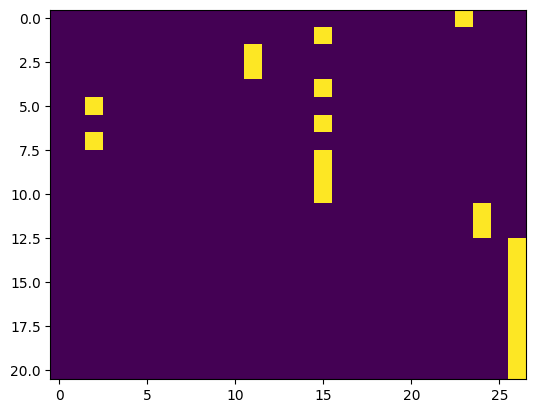

In [16]:
plt.imshow(np.array(one_hot_vectors)[310,:,:])

20. Now, let's explore the properties of the latent space of this dataset. Using ChaGPT:
- Write the AE using the encoded smiles as an input with 2D latent space
-  Visualize the latent distribution and representation
- Experiment with difefrent attributes from data frame as labels, and see how they are distirbuted in latent space

21. Do the same with the VAE, also with 2D latent space

22. Write the VAE with the 10D latent space. Suggest an approach to visualize the latent space

23. Describe the difference between AE and VAE latent distirbutions

Answer:

24. Explore the variability of
- dipole momentum,
- number of rings
- mole log P over latent spaces.
What conclusions can you make?

# 5.Example: ChatGPT VAE on QM9

This is example of the ChatGPT written VAE on the QM9 - just to make sure everything works. This is not a part of the Midterm.

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [18]:
input_shape = (21, 27)
original_dim = np.prod(input_shape)
latent_dim = 2

# Encoder
inputs = Input(shape=input_shape)
x = Flatten()(inputs)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# Decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(latent_inputs)
x = Dense(original_dim, activation='sigmoid')(x)
outputs = Reshape(input_shape)(x)

# Instantiate models
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE Model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# VAE Loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs)) * original_dim
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


In [19]:
data = np.array(one_hot_vectors)
vae.fit(data, epochs=100, batch_size=64)

Epoch 1/100
79/79 [==============================] - 9s 5ms/step - loss: 174.7021
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 54.1956
Epoch 3/100
79/79 [==============================] - 0s 4ms/step - loss: 48.2736
Epoch 4/100
79/79 [==============================] - 0s 4ms/step - loss: 45.7384
Epoch 5/100
79/79 [==============================] - 0s 4ms/step - loss: 43.8296
Epoch 6/100
79/79 [==============================] - 0s 4ms/step - loss: 42.1914
Epoch 7/100
79/79 [==============================] - 0s 4ms/step - loss: 41.3291
Epoch 8/100
79/79 [==============================] - 0s 4ms/step - loss: 40.5315
Epoch 9/100
79/79 [==============================] - 0s 4ms/step - loss: 40.0781
Epoch 10/100
79/79 [==============================] - 0s 4ms/step - loss: 39.6901
Epoch 11/100
79/79 [==============================] - 0s 4ms/step - loss: 39.3071
Epoch 12/100
79/79 [==============================] - 0s 4ms/step - loss: 38.9585
Epoch 13/100
79/79 [====

In [20]:
def plot_latent_representation(decoder, height=21, width=27, n=15):
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)
    figure = np.zeros((height * n, width * n))
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(height, width)
            figure[i * height: (i + 1) * height, j * width: (j + 1) * width] = digit
    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.axis('off')
    plt.show()


In [21]:
def plot_latent_space(encoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c = labels)
    plt.colorbar()
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.title('Latent Space')
    plt.show()


1/1 [==============================] - 0s 21ms/step


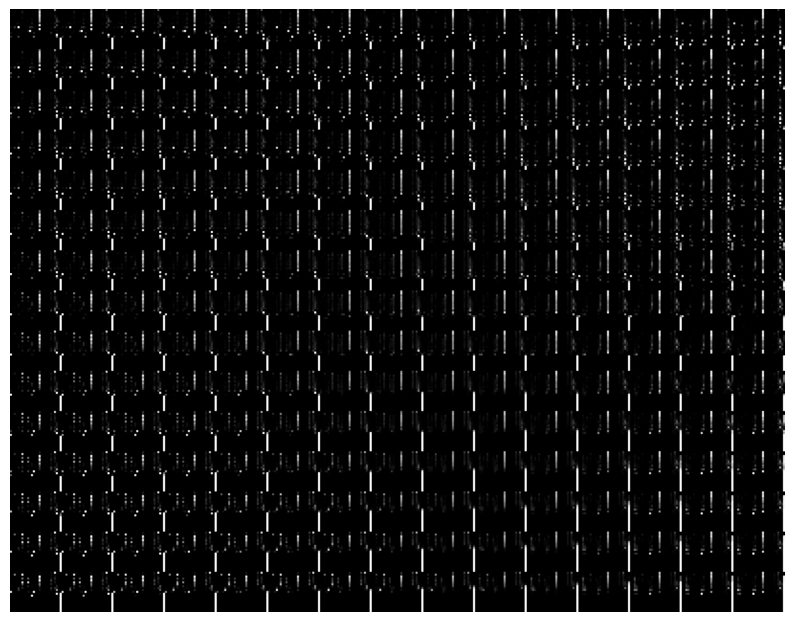

In [22]:
plot_latent_representation(decoder)

157/157 [==============================] - 0s 1ms/step


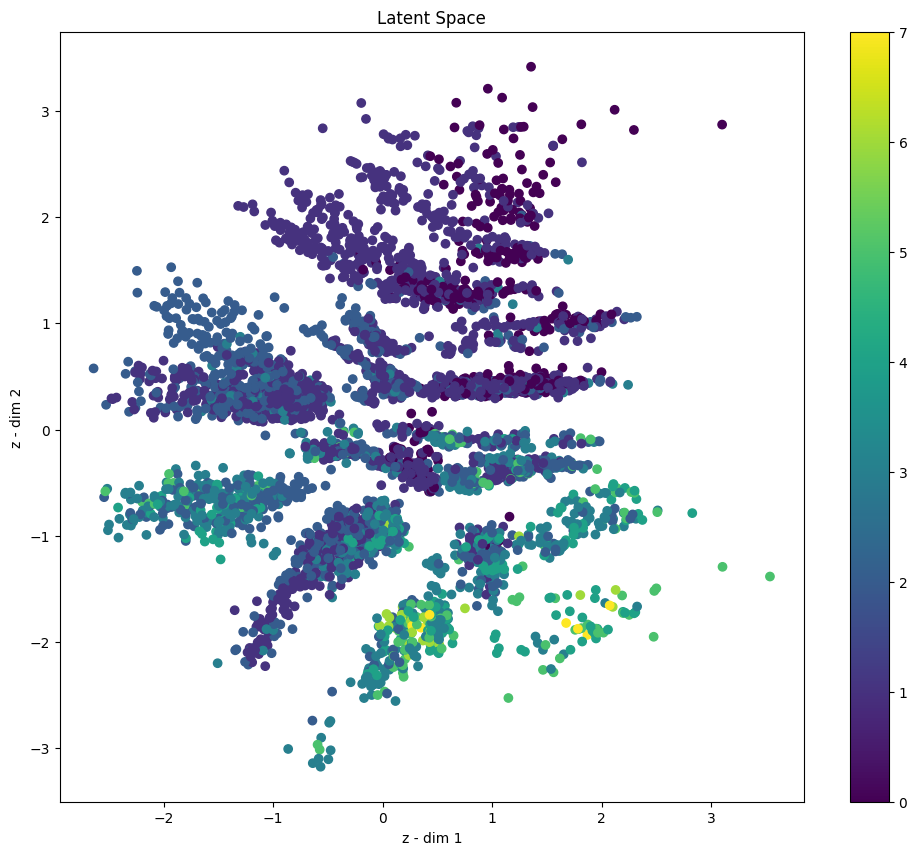

In [23]:
plot_latent_space(encoder, data, labels = df_filtered['ringct'])